In [55]:
from torchvision import transforms, models
import torch.nn as nn
import torch
from PIL import Image
import matplotlib.pyplot as plt

In [11]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# Core transforms for any images
base_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [12]:
# Loading model
model = models.efficientnet_b7(pretrained=False)
unfreeze_num = 3
number_of_classes = 101
for param in model.features[:-unfreeze_num].parameters():
    param.requires_grad = False
model.classifier = nn.Linear(in_features=2560, out_features=number_of_classes, bias=True)
model.load_state_dict(torch.load(r"C:\Users\ilasmej\Documents\GitHub\recipe-by-photo-telegram-bot\efficientnet_b7_state_dict.pth", map_location=torch.device('cpu')))

c:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [14]:
# Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        
        #encoder
        self.pool = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        

        # decoder (upsampling)
        self.upsample = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3)
        )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool(self.enc_conv0(x))
        e1, ind1 = self.pool(self.enc_conv1(e0))
        e2, ind2 = self.pool(self.enc_conv2(e1))
        e3, ind3 = self.pool(self.enc_conv3(e2))

        # decoder
        d0 = self.upsample(e3, indices=ind3)
        d1 = self.upsample(self.dec_conv0(d0), indices=ind2)
        d2 = self.upsample(self.dec_conv1(d1), indices=ind1)
        d3 = self.upsample(self.dec_conv2(d2), indices=ind0)
        return self.dec_conv3(d3)

In [19]:
# Loading autoencoder
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load(r"C:\Users\ilasmej\Documents\GitHub\recipe-by-photo-telegram-bot\autoencoder.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

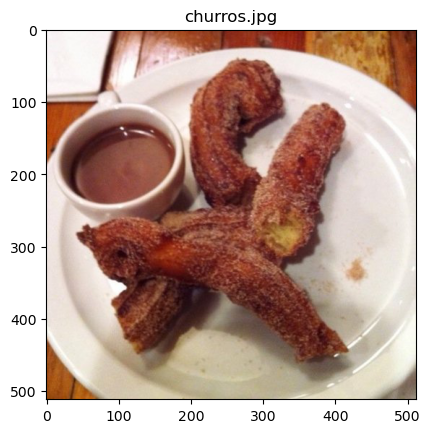

In [57]:
filepath = r"C:\Users\ilasmej\Documents\GitHub\recipe-by-photo-telegram-bot\test\churros.jpg"
image = Image.open(filepath)
title = filepath.split("\\")[-1]
plt.imshow(image)
plt.title(title)
image = base_transforms(image).unsqueeze(0)

In [63]:
with open(r"C:\Users\ilasmej\Documents\GitHub\recipe-by-photo-telegram-bot\meta\classes.txt", "r") as file:
    line = file.readlines()
    classes_names = [class_name.strip() for class_name in line]

In [59]:
model.eval()
with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output.data, 1)
    print(classes_names[predicted.item()])

churros
